In [1]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()

Saving RecordingData.zip to RecordingData.zip


In [3]:
zip_path = "RecordingData.zip"
extract_dir = "eye_data_unzipped"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
import os
import zipfile
import glob
import numpy as np
import pandas as pd


# ============================================================
# 2. Basic helpers
# ============================================================
def compute_version_vergence(df):
    """
    Add version (VX, VY) and vergence (GX, GY) columns.
    VX/VY  = (LX + RX) / 2
    GX/GY  =  LX - RX
    """
    df = df.copy()
    df["VX"] = (df["LX"] + df["RX"]) / 2.0
    df["VY"] = (df["LY"] + df["RY"]) / 2.0
    df["GX"] = df["LX"] - df["RX"]
    df["GY"] = df["LY"] - df["RY"]
    return df


def detect_sampling_rate(df):
    """
    Estimate sampling rate from the T column (assumed ms).
    """
    diffs = np.diff(df["T"].values.astype(float))
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return 100.0
    mean_interval = np.mean(diffs)
    if mean_interval <= 0:
        return 100.0
    return float(np.round(1000.0 / mean_interval, 1))



In [5]:

# ============================================================
# 3. Dynamic dispersion state machine
# ============================================================
def _rms_noise(values):
    """
    RMS of (values - mean(values)).
    Used as signal noise estimate over the last 25 samples.
    """
    if len(values) < 2:
        return 0.0
    v = np.array(values, dtype=float)
    mu = v.mean()
    return float(np.sqrt(np.mean((v - mu) ** 2)))


def detect_states_dynamic(df,
                          base_threshold_deg=0.5,
                          noise_factor=2.5,
                          min_fix_dur_ms=50.0):
    """
    Dynamic dispersion threshold algorithm (paper style).

    - Uses version signal as CH (horizontal) and CV (vertical).
    - Instantaneous "state" internally:
        * 'stable'  -> eventually becomes fixation/transient
        * 'moving'  -> becomes saccade
        * 'distortion' -> missing signal
    - A stable segment is labeled:
        * fixation  if duration >= min_fix_dur_ms
        * transient otherwise
    - A moving segment is labeled saccade.
    - Distortion segments remain distortion.
    """
    n = len(df)
    if n == 0:
        return []

    # CH / CV = version
    CH = ((df["LX"] + df["RX"]) / 2.0).values.astype(float)
    CV = ((df["LY"] + df["RY"]) / 2.0).values.astype(float)
    T = df["T"].values.astype(float)

    # approximate dt from median diff
    diffs = np.diff(T)
    diffs = diffs[diffs > 0]
    dt_ms = np.median(diffs) if len(diffs) > 0 else 10.0
    min_fix_samples = max(1, int(np.ceil(min_fix_dur_ms / dt_ms)))

    events = []

    current_state = None          # 'stable', 'moving', 'distortion'
    state_start = 0
    state_CH = []
    state_CV = []
    tail_CH = []
    tail_CV = []

    def close_state(end_idx):
        nonlocal current_state, state_start, state_CH, state_CV, tail_CH, tail_CV
        if current_state is None:
            return
        start_idx = state_start
        if end_idx < start_idx:
            return

        start_time = T[start_idx]
        end_time = T[end_idx]
        duration = end_time - start_time

        # label according to the paper rules
        if current_state == "distortion":
            label = "distortion"
        elif current_state == "stable":
            if (end_idx - start_idx + 1) >= min_fix_samples:
                label = "fixation"
            else:
                label = "transient"
        elif current_state == "moving":
            label = "saccade"
        else:
            label = "transient"

        events.append({
            "state": label,
            "start_idx": start_idx,
            "end_idx": end_idx,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
        })

        # reset state buffers
        current_state = None
        state_start = end_idx + 1
        state_CH = []
        state_CV = []
        tail_CH = []
        tail_CV = []

    for i in range(n):
        lx = df["LX"].iloc[i]
        rx = df["RX"].iloc[i]
        ly = df["LY"].iloc[i]
        ry = df["RY"].iloc[i]

        # 1) Distortion: any signal missing
        if np.isnan(lx) or np.isnan(rx) or np.isnan(ly) or np.isnan(ry):
            new_state = "distortion"
            if current_state is not None and current_state != new_state:
                close_state(i - 1)
            if current_state is None:
                current_state = new_state
                state_start = i
            continue

        x = CH[i]
        y = CV[i]

        # update buffers
        tail_CH.append(x)
        tail_CV.append(y)
        state_CH.append(x)
        state_CV.append(y)

        if len(tail_CH) > 25:
            tail_CH.pop(0)
            tail_CV.pop(0)

        # dynamic threshold = 0.5 deg + 2.5 * RMS noise
        noise_x = _rms_noise(tail_CH)
        noise_y = _rms_noise(tail_CV)
        threshold = base_threshold_deg + noise_factor * max(noise_x, noise_y)

        # distance from current state's mean
        if len(state_CH) > 0:
            mu_x = float(np.mean(state_CH))
            mu_y = float(np.mean(state_CV))
            dist = np.sqrt((x - mu_x) ** 2 + (y - mu_y) ** 2)
        else:
            dist = 0.0

        stable = dist <= threshold
        new_state = "stable" if stable else "moving"

        if current_state is None:
            current_state = new_state
            state_start = i
        elif current_state in ["stable", "moving"]:
            if new_state != current_state:
                # state change: close previous segment
                close_state(i - 1)
                current_state = new_state
                state_start = i
                state_CH = [x]
                state_CV = [y]
        elif current_state == "distortion":
            if new_state != "distortion":
                close_state(i - 1)
                current_state = new_state
                state_start = i
                state_CH = [x]
                state_CV = [y]

    # close last state
    close_state(n - 1)

    return events


In [6]:
# ============================================================
# 4. From states → fixations + saccades with direction
# ============================================================
def label_fixations_saccades(events, df):
    """
    - Keep only fixation and saccade events.
    - For saccades: direction = progressive (ΔVX > 0) or regressive (ΔVX <= 0).
    - For fixations: direction = direction of preceding saccade
      (as described in the paper).
    """
    VX = ((df["LX"] + df["RX"]) / 2.0).values.astype(float)

    # step 1: give directions to saccades
    for ev in events:
        if ev["state"] == "saccade":
            s = ev["start_idx"]
            e = ev["end_idx"]
            if e <= s:
                ev["direction"] = "unknown"
            else:
                delta = VX[e] - VX[s]
                ev["direction"] = "progressive" if delta > 0 else "regressive"
        else:
            ev["direction"] = "unknown"

    # step 2: propagate direction to following fixations
    last_dir = "unknown"
    for ev in events:
        if ev["state"] == "saccade":
            last_dir = ev["direction"]
        elif ev["state"] == "fixation":
            ev["direction"] = last_dir

    # keep only fixations & saccades
    fs = [ev for ev in events if ev["state"] in ["fixation", "saccade"]]
    return fs


In [7]:
# ============================================================
# 5. Per-event feature computation
# ============================================================
def compute_single_event_features(df, ev):
    """
    Paper's 6 parameter types, each measured for version x/y and vergence x/y:

        (1) duration
        (2) distance spanning the event        → version_x/y_distance, vergence_x/y_distance
        (3) average eye position               → version_x/y_mean,     vergence_x/y_mean
        (4) std of position                    → version_x/y_std,      vergence_x/y_std
        (5) max range between any two positions → version_x/y_range,    vergence_x/y_range
        (6) accumulated distance               → version_x/y_accum,    vergence_x/y_accum

    Total: 1 + (5 × 4) = 21 parameters per event
    """
    s, e = ev["start_idx"], ev["end_idx"]
    seg  = df.iloc[s:e+1]

    VX = seg["VX"].values.astype(float)
    VY = seg["VY"].values.astype(float)
    GX = seg["GX"].values.astype(float)
    GY = seg["GY"].values.astype(float)

    def accum(arr):
        """Sum of absolute differences (1D path length)."""
        return float(np.sum(np.abs(np.diff(arr)))) if len(arr) > 1 else 0.0

    return {
        "event_type": ev["state"],
        "direction":  ev["direction"],

        # (1) duration
        "duration":                  float(ev["duration"]),

        # (2) distance spanning the event (end - start, signed)
        "version_x_distance":       float(VX[-1] - VX[0]),
        "version_y_distance":       float(VY[-1] - VY[0]),
        "vergence_x_distance":      float(GX[-1] - GX[0]),
        "vergence_y_distance":      float(GY[-1] - GY[0]),

        # (3) average position
        "version_x_mean":           float(VX.mean()),
        "version_y_mean":           float(VY.mean()),
        "vergence_x_mean":          float(GX.mean()),
        "vergence_y_mean":          float(GY.mean()),

        # (4) std of position
        "version_x_std":            float(VX.std(ddof=0)),
        "version_y_std":            float(VY.std(ddof=0)),
        "vergence_x_std":           float(GX.std(ddof=0)),
        "vergence_y_std":           float(GY.std(ddof=0)),

        # (5) max range (max - min)
        "version_x_range":          float(VX.max() - VX.min()),
        "version_y_range":          float(VY.max() - VY.min()),
        "vergence_x_range":         float(GX.max() - GX.min()),
        "vergence_y_range":         float(GY.max() - GY.min()),

        # (6) accumulated distance (1D path length per axis)
        "version_x_accum":          accum(VX),
        "version_y_accum":          accum(VY),
        "vergence_x_accum":         accum(GX),
        "vergence_y_accum":         accum(GY),
    }


def build_event_dataframe(df, events_fs):
    """Turn fixation/saccade event list into a per-event DataFrame."""
    rows = [compute_single_event_features(df, ev) for ev in events_fs]
    if len(rows) == 0:
        return pd.DataFrame()
    return pd.DataFrame(rows)


In [8]:
# ============================================================
# 6. Summarize to exactly 168 features (subject-level)
# ============================================================
def summarize_168_features(events_df):
    """
    4 event types × 21 parameters × 2 stats (mean, std) = 168 features

    Event types:
        fix_prog  : fixations after progressive saccades
        fix_reg   : fixations after regressive saccades
        sac_prog  : progressive saccades
        sac_reg   : regressive saccades

    21 parameters per event:
        duration (1)
        + distance, mean, std, range, accum × version x/y & vergence x/y (5 × 4 = 20)
    """
    summary = {}

    groups = {
        "fix_prog": (events_df["event_type"] == "fixation") & (events_df["direction"] == "progressive"),
        "fix_reg":  (events_df["event_type"] == "fixation") & (events_df["direction"] == "regressive"),
        "sac_prog": (events_df["event_type"] == "saccade")  & (events_df["direction"] == "progressive"),
        "sac_reg":  (events_df["event_type"] == "saccade")  & (events_df["direction"] == "regressive"),
    }

    # 21 parameters — must match keys in compute_single_event_features
    feature_cols = [
        "duration",
        "version_x_distance",  "version_y_distance",  "vergence_x_distance",  "vergence_y_distance",
        "version_x_mean",      "version_y_mean",      "vergence_x_mean",      "vergence_y_mean",
        "version_x_std",       "version_y_std",       "vergence_x_std",       "vergence_y_std",
        "version_x_range",     "version_y_range",     "vergence_x_range",     "vergence_y_range",
        "version_x_accum",     "version_y_accum",     "vergence_x_accum",     "vergence_y_accum",
    ]

    for gname, mask in groups.items():
        g = events_df[mask]

        if len(g) == 0:
            for col in feature_cols:
                summary[f"{gname}_{col}_mean"] = 0.0
                summary[f"{gname}_{col}_std"]  = 0.0
        else:
            for col in feature_cols:
                vals = g[col].values.astype(float)
                summary[f"{gname}_{col}_mean"] = float(np.mean(vals))
                summary[f"{gname}_{col}_std"]  = float(np.std(vals, ddof=0))

    return pd.Series(summary)


In [9]:
all_features = []

for file in glob.glob(os.path.join(extract_dir, "**/*.txt"), recursive=True):
    base = os.path.basename(file)
    if base.lower().startswith("info"):
        continue  # skip meta files

    try:
        df = pd.read_csv(file, sep="\t", decimal=",", engine="python")
    except Exception as e:
        print(f"Failed to read {file}: {e}")
        continue

    # Required columns
    required_cols = {"T", "LX", "LY", "RX", "RY"}
    if not required_cols.issubset(df.columns):
        print(f"⚠️ Skipping {file} — missing required columns.")
        continue

    # Ensure numeric
    for c in required_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Sort by time
    df = df.sort_values("T").reset_index(drop=True)

    # Compute version/vergence
    df = compute_version_vergence(df)

    # Sampling rate
    sampling_rate = detect_sampling_rate(df)

    # Detect fixations/saccades
    states = detect_states_dynamic(df)
    fs_events = label_fixations_saccades(states, df)

    # Compute per-event features including vergence spans/distances
    events_df = build_event_dataframe(df, fs_events)
    if len(events_df) == 0:
        print(f"⚠️ No events found in {file}. Skipping.")
        continue

    # Summarize to 168 subject-level features
    feat = summarize_168_features(events_df)

    # Add metadata
    feat["file"] = file
    feat["sampling_rate"] = sampling_rate
    feat["n_fixations"] = int((events_df["event_type"] == "fixation").sum())
    feat["n_saccades"]  = int((events_df["event_type"] == "saccade").sum())

    all_features.append(feat)
    print(f"Processed {file}: fix={feat['n_fixations']}, sac={feat['n_saccades']}")

# Save all features to CSV
if len(all_features) > 0:
    all_df = pd.DataFrame(all_features)
    all_df.to_csv("eye_features_168.csv", index=False)
    print("\n✅ DONE. Saved → eye_features_168.csv")
else:
    print("\n⚠️ No valid files processed.")


⚠️ Skipping eye_data_unzipped/Recording Data/Subject codes.txt — missing required columns.
Processed eye_data_unzipped/Recording Data/343BJ3/A1R.txt: fix=48, sac=116
Processed eye_data_unzipped/Recording Data/755TD3/A1R.txt: fix=58, sac=203
Processed eye_data_unzipped/Recording Data/795JM1/A1R.txt: fix=63, sac=204
Processed eye_data_unzipped/Recording Data/796NT3/A1R.txt: fix=51, sac=143
Processed eye_data_unzipped/Recording Data/342GD1/A1R.txt: fix=82, sac=107
Processed eye_data_unzipped/Recording Data/132AD3/A1R.txt: fix=67, sac=169
Processed eye_data_unzipped/Recording Data/752NA1/A1R.txt: fix=71, sac=73
Processed eye_data_unzipped/Recording Data/725MF1/A1R.txt: fix=77, sac=103
Processed eye_data_unzipped/Recording Data/322RE1/A1R.txt: fix=67, sac=184
Processed eye_data_unzipped/Recording Data/794GO3/A1R.txt: fix=51, sac=125
Processed eye_data_unzipped/Recording Data/781PT1/A1R.txt: fix=78, sac=111
Processed eye_data_unzipped/Recording Data/346KU1/A1R.txt: fix=70, sac=199
Processed 

In [10]:
import pandas as pd

df = pd.read_csv("eye_features_168.csv")

print("Nulls in file column:", df["file"].isna().sum())
print("Example values:")
print(df["file"].head(20).tolist())

# Find the bad ones (no slash and no backslash)
bad = df[df["file"].astype(str).apply(lambda s: ("/" not in s) and ("\\" not in s))]
print("Bad rows count:", len(bad))
print(bad["file"].head(20).tolist())


Nulls in file column: 0
Example values:
['eye_data_unzipped/Recording Data/343BJ3/A1R.txt', 'eye_data_unzipped/Recording Data/755TD3/A1R.txt', 'eye_data_unzipped/Recording Data/795JM1/A1R.txt', 'eye_data_unzipped/Recording Data/796NT3/A1R.txt', 'eye_data_unzipped/Recording Data/342GD1/A1R.txt', 'eye_data_unzipped/Recording Data/132AD3/A1R.txt', 'eye_data_unzipped/Recording Data/752NA1/A1R.txt', 'eye_data_unzipped/Recording Data/725MF1/A1R.txt', 'eye_data_unzipped/Recording Data/322RE1/A1R.txt', 'eye_data_unzipped/Recording Data/794GO3/A1R.txt', 'eye_data_unzipped/Recording Data/781PT1/A1R.txt', 'eye_data_unzipped/Recording Data/346KU1/A1R.txt', 'eye_data_unzipped/Recording Data/781SD3/A1R.txt', 'eye_data_unzipped/Recording Data/724OP3/A1R.txt', 'eye_data_unzipped/Recording Data/772AK3/A1R.txt', 'eye_data_unzipped/Recording Data/142EJ1/A1R.txt', 'eye_data_unzipped/Recording Data/794LA3/A1R.txt', 'eye_data_unzipped/Recording Data/723SJ1/A1R.txt', 'eye_data_unzipped/Recording Data/726OG1/

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("eye_features_168.csv")

def get_subject_code(file_path):
    # normalize Windows \ to /
    s = str(file_path).replace("\\", "/")
    folder_name = s.split("/")[-2]      # e.g. "111GM3"
    return int(folder_name[-1])         # -> 3

df["subject_code"] = df["file"].apply(get_subject_code)

print(df[["file", "subject_code"]].head())
print(df["subject_code"].value_counts())


# Apply function to create 'subject_code' column
df['subject_code'] = df['file'].apply(get_subject_code)

# Function to assign risk group
def assign_risk(code):
    if code in [1, 2]:
        return 'High Risk'
    elif code in [3, 4]:
        return 'Low Risk'
    else:
        return 'Unknown'

# Function to assign gender
def assign_gender(code):
    if code in [1, 3]:
        return 'Male'
    elif code in [2, 4]:
        return 'Female'
    else:
        return 'Unknown'

# Apply functions to create 'risk_group' and 'gender' columns
df['risk_group'] = df['subject_code'].apply(assign_risk)
df['gender'] = df['subject_code'].apply(assign_gender)

# Convert categorical to numeric for machine learning
df['risk_group_label'] = df['risk_group'].map({'High Risk': 1, 'Low Risk': 0})
df['gender_label'] = df['gender'].map({'Male': 1, 'Female': 0})

# Save updated DataFrame to a new CSV
df.to_csv("eye_features_with_labels.csv", index=False)

print("Columns added and CSV saved successfully!")
print(df[['file','subject_code','risk_group','gender','risk_group_label','gender_label']].head())
print(df['risk_group'].value_counts(dropna=False))
print(df[df['risk_group'].isin(['Unknown'])][['file','subject_code']].head(10))


                                              file  subject_code
0  eye_data_unzipped/Recording Data/343BJ3/A1R.txt             3
1  eye_data_unzipped/Recording Data/755TD3/A1R.txt             3
2  eye_data_unzipped/Recording Data/795JM1/A1R.txt             1
3  eye_data_unzipped/Recording Data/796NT3/A1R.txt             3
4  eye_data_unzipped/Recording Data/342GD1/A1R.txt             1
subject_code
1    76
3    69
2    21
4    19
Name: count, dtype: int64
Columns added and CSV saved successfully!
                                              file  subject_code risk_group  \
0  eye_data_unzipped/Recording Data/343BJ3/A1R.txt             3   Low Risk   
1  eye_data_unzipped/Recording Data/755TD3/A1R.txt             3   Low Risk   
2  eye_data_unzipped/Recording Data/795JM1/A1R.txt             1  High Risk   
3  eye_data_unzipped/Recording Data/796NT3/A1R.txt             3   Low Risk   
4  eye_data_unzipped/Recording Data/342GD1/A1R.txt             1  High Risk   

  gender  risk_group_l

In [12]:
df = pd.read_csv("eye_features_with_labels.csv")
print(df['risk_group'].value_counts(dropna=False))
print(df['gender'].value_counts(dropna=False))
print("Unknown rows:", (df['risk_group']=="Unknown").sum(), (df['gender']=="Unknown").sum())


risk_group
High Risk    97
Low Risk     88
Name: count, dtype: int64
gender
Male      145
Female     40
Name: count, dtype: int64
Unknown rows: 0 0


In [13]:
import pandas as pd

df = pd.read_csv("eye_features_with_labels.csv")  # change filename if needed

print("Total columns:", len(df.columns))
for i, col in enumerate(df.columns):
    print(i, col)


Total columns: 177
0 fix_prog_duration_mean
1 fix_prog_duration_std
2 fix_prog_version_x_distance_mean
3 fix_prog_version_x_distance_std
4 fix_prog_version_y_distance_mean
5 fix_prog_version_y_distance_std
6 fix_prog_vergence_x_distance_mean
7 fix_prog_vergence_x_distance_std
8 fix_prog_vergence_y_distance_mean
9 fix_prog_vergence_y_distance_std
10 fix_prog_version_x_mean_mean
11 fix_prog_version_x_mean_std
12 fix_prog_version_y_mean_mean
13 fix_prog_version_y_mean_std
14 fix_prog_vergence_x_mean_mean
15 fix_prog_vergence_x_mean_std
16 fix_prog_vergence_y_mean_mean
17 fix_prog_vergence_y_mean_std
18 fix_prog_version_x_std_mean
19 fix_prog_version_x_std_std
20 fix_prog_version_y_std_mean
21 fix_prog_version_y_std_std
22 fix_prog_vergence_x_std_mean
23 fix_prog_vergence_x_std_std
24 fix_prog_vergence_y_std_mean
25 fix_prog_vergence_y_std_std
26 fix_prog_version_x_range_mean
27 fix_prog_version_x_range_std
28 fix_prog_version_y_range_mean
29 fix_prog_version_y_range_std
30 fix_prog_vergen

Dataset: 185 subjects, 168 features
Class distribution: [88 97]

Starting 100 × 10-fold CV with RFE feature selection...
Testing feature counts: 1 to 168

Progress: 10/1000 folds completed (1.0%)
Progress: 20/1000 folds completed (2.0%)
Progress: 30/1000 folds completed (3.0%)
Progress: 40/1000 folds completed (4.0%)
Progress: 50/1000 folds completed (5.0%)
Progress: 60/1000 folds completed (6.0%)
Progress: 70/1000 folds completed (7.0%)
Progress: 80/1000 folds completed (8.0%)
Progress: 90/1000 folds completed (9.0%)
Progress: 100/1000 folds completed (10.0%)
Progress: 110/1000 folds completed (11.0%)
Progress: 120/1000 folds completed (12.0%)
Progress: 130/1000 folds completed (13.0%)
Progress: 140/1000 folds completed (14.0%)
Progress: 150/1000 folds completed (15.0%)
Progress: 160/1000 folds completed (16.0%)
Progress: 170/1000 folds completed (17.0%)
Progress: 180/1000 folds completed (18.0%)
Progress: 190/1000 folds completed (19.0%)
Progress: 200/1000 folds completed (20.0%)
Pro

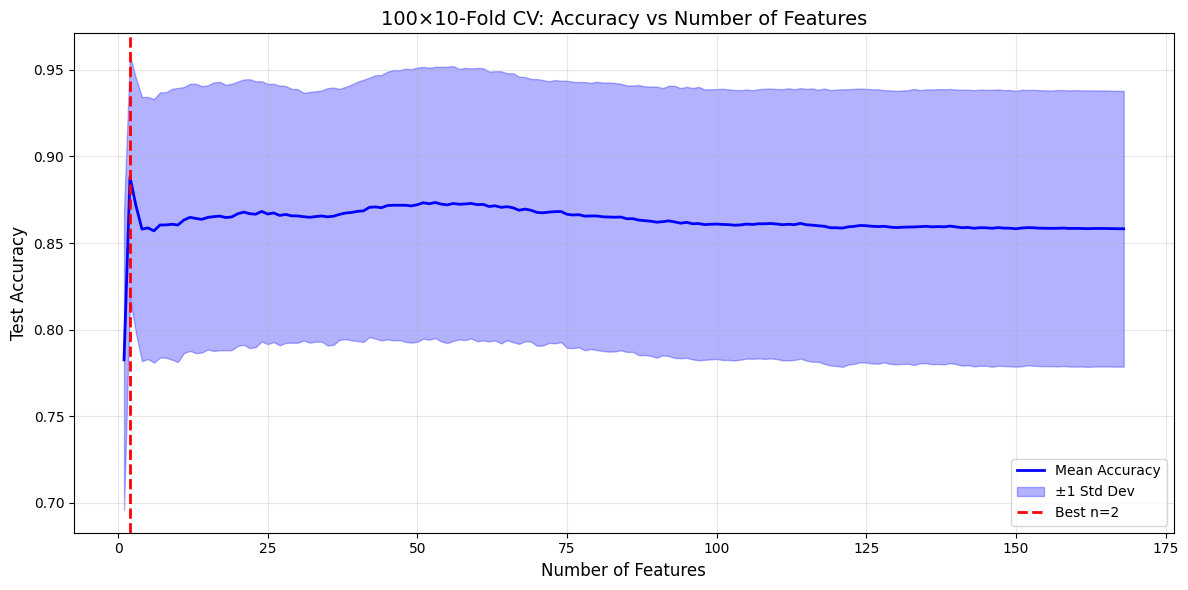

In [33]:
# ============================================================
# IMPORTS AND DATA LOADING
# ============================================================
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score


# Load dataset
df = pd.read_csv("eye_features_with_labels.csv")

# Select features and target
EXCLUDE_COLS = {"file","risk_group","gender","risk_group_label","gender_label","subject_code"}
META_FEATURES = {"sampling_rate","n_fixations","n_saccades"}

feature_cols = [c for c in df.columns if c not in EXCLUDE_COLS and c not in META_FEATURES]
X = df[feature_cols].astype(float).values
y = df["risk_group_label"].astype(int).values

print(f"Dataset: {len(X)} subjects, {X.shape[1]} features")
print(f"Class distribution: {np.bincount(y)}")

# ============================================================
# SETUP AND CROSS-VALIDATION LOOP
# ============================================================
# Parameters
n_splits = 10
n_repeats = 100
C_VALUE = 0.1

n_features_total = X.shape[1]
feature_counts_to_test = range(1, n_features_total + 1)

# Store results: dict[n_features] -> list of metrics
results = {n: [] for n in feature_counts_to_test}
# Store ALL predictions for aggregated confusion matrix
# Store ALL predictions for aggregated confusion matrix + ROC
all_predictions = {
    n: {'y_true': [], 'y_pred': [], 'y_score': []}
    for n in feature_counts_to_test}

# Store confusion matrices per fold for mean ± std calculation
confusion_matrices = {n: [] for n in feature_counts_to_test}
# Store selected features for each n_features count
selected_features_tracker = {n: [] for n in feature_counts_to_test}

print(f"\nStarting {n_repeats} × {n_splits}-fold CV with RFE feature selection...")
print(f"Testing feature counts: 1 to {n_features_total}\n")

total_iterations = n_repeats * n_splits
current_iteration = 0

for repeat in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        current_iteration += 1
        if current_iteration % 10 == 0:
            print(f"Progress: {current_iteration}/{total_iterations} folds completed ({100*current_iteration/total_iterations:.1f}%)")

        X_train_raw, X_test_raw = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_raw)
        X_test = scaler.transform(X_test_raw)

        # RFE to rank all features
        svm_rfe = SVC(kernel='linear', C=C_VALUE,probability=True)
        rfe = RFE(estimator=svm_rfe, n_features_to_select=1, step=1)
        rfe.fit(X_train, y_train)

        feature_ranking = rfe.ranking_
        ranked_indices = np.argsort(feature_ranking)

        for n_features in feature_counts_to_test:
            selected_features = ranked_indices[:n_features]

            # Track which features were selected
            selected_features_tracker[n_features].append(selected_features.tolist())

            svm = SVC(kernel='linear', C=C_VALUE,probability=True)
            svm.fit(X_train[:, selected_features], y_train)
            y_pred = svm.predict(X_test[:, selected_features])

            acc = accuracy_score(y_test, y_pred)

            # Confusion matrix for sensitivity & specificity
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

            # Store confusion matrix for this fold
            confusion_matrices[n_features].append(cm)

            # Precision, Recall, F1 per class
            precision, recall, f1, support = precision_recall_fscore_support(
                y_test, y_pred, labels=[0, 1], zero_division=0
            )

            # Macro and weighted averages
            precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
                y_test, y_pred, average='macro', zero_division=0
            )
            precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
                y_test, y_pred, average='weighted', zero_division=0
            )

            results[n_features].append({
                'accuracy': acc,
                'sensitivity': sensitivity,
                'specificity': specificity,
                # Per-class metrics (LR = class 0, HR = class 1)
                'precision_LR': precision[0],
                'recall_LR': recall[0],
                'f1_LR': f1[0],
                'precision_HR': precision[1],
                'recall_HR': recall[1],
                'f1_HR': f1[1],
                # Macro averages
                'precision_macro': precision_macro,
                'recall_macro': recall_macro,
                'f1_macro': f1_macro,
                # Weighted averages
                'precision_weighted': precision_weighted,
                'recall_weighted': recall_weighted,
                'f1_weighted': f1_weighted,
            })

            # Store ALL predictions for aggregated confusion matrix
            all_predictions[n_features]['y_true'].extend(y_test)
            all_predictions[n_features]['y_pred'].extend(y_pred)
            all_predictions[n_features]['y_score'].extend( svm.predict_proba(X_test[:, selected_features])[:, 1])
print(f"\nCompleted all {total_iterations} folds!\n")

# ============================================================
#  ANALYZE RESULTS AND COMPUTE STATISTICS
# ============================================================
mean_accuracies = []
std_accuracies = []
mean_sensitivities = []
std_sensitivities = []
mean_specificities = []
std_specificities = []

# Per-class metrics
mean_precision_LR = []
std_precision_LR = []
mean_recall_LR = []
std_recall_LR = []
mean_f1_LR = []
std_f1_LR = []

mean_precision_HR = []
std_precision_HR = []
mean_recall_HR = []
std_recall_HR = []
mean_f1_HR = []
std_f1_HR = []

# Macro averages
mean_precision_macro = []
std_precision_macro = []
mean_recall_macro = []
std_recall_macro = []
mean_f1_macro = []
std_f1_macro = []

# Weighted averages
mean_precision_weighted = []
std_precision_weighted = []
mean_recall_weighted = []
std_recall_weighted = []
mean_f1_weighted = []
std_f1_weighted = []

for n_features in feature_counts_to_test:
    metrics = results[n_features]

    accs = np.array([m['accuracy'] for m in metrics])
    sens = np.array([m['sensitivity'] for m in metrics])
    spec = np.array([m['specificity'] for m in metrics])

    # LR class
    prec_lr = np.array([m['precision_LR'] for m in metrics])
    rec_lr = np.array([m['recall_LR'] for m in metrics])
    f1_lr = np.array([m['f1_LR'] for m in metrics])

    # HR class
    prec_hr = np.array([m['precision_HR'] for m in metrics])
    rec_hr = np.array([m['recall_HR'] for m in metrics])
    f1_hr = np.array([m['f1_HR'] for m in metrics])

    # Macro
    prec_macro = np.array([m['precision_macro'] for m in metrics])
    rec_macro = np.array([m['recall_macro'] for m in metrics])
    f1_macro = np.array([m['f1_macro'] for m in metrics])

    # Weighted
    prec_weighted = np.array([m['precision_weighted'] for m in metrics])
    rec_weighted = np.array([m['recall_weighted'] for m in metrics])
    f1_weighted = np.array([m['f1_weighted'] for m in metrics])

    mean_accuracies.append(accs.mean())
    std_accuracies.append(accs.std())
    mean_sensitivities.append(sens.mean())
    std_sensitivities.append(sens.std())
    mean_specificities.append(spec.mean())
    std_specificities.append(spec.std())

    # LR
    mean_precision_LR.append(prec_lr.mean())
    std_precision_LR.append(prec_lr.std())
    mean_recall_LR.append(rec_lr.mean())
    std_recall_LR.append(rec_lr.std())
    mean_f1_LR.append(f1_lr.mean())
    std_f1_LR.append(f1_lr.std())

    # HR
    mean_precision_HR.append(prec_hr.mean())
    std_precision_HR.append(prec_hr.std())
    mean_recall_HR.append(rec_hr.mean())
    std_recall_HR.append(rec_hr.std())
    mean_f1_HR.append(f1_hr.mean())
    std_f1_HR.append(f1_hr.std())

    # Macro
    mean_precision_macro.append(prec_macro.mean())
    std_precision_macro.append(prec_macro.std())
    mean_recall_macro.append(rec_macro.mean())
    std_recall_macro.append(rec_macro.std())
    mean_f1_macro.append(f1_macro.mean())
    std_f1_macro.append(f1_macro.std())

    # Weighted
    mean_precision_weighted.append(prec_weighted.mean())
    std_precision_weighted.append(prec_weighted.std())
    mean_recall_weighted.append(rec_weighted.mean())
    std_recall_weighted.append(rec_weighted.std())
    mean_f1_weighted.append(f1_weighted.mean())
    std_f1_weighted.append(f1_weighted.std())

mean_accuracies = np.array(mean_accuracies)
std_accuracies = np.array(std_accuracies)

best_idx = np.argmax(mean_accuracies)
best_n = list(feature_counts_to_test)[best_idx]

# ============================================================
#  CREATE AND SAVE PLOT
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(list(feature_counts_to_test), mean_accuracies, 'b-', linewidth=2, label='Mean Accuracy')
plt.fill_between(list(feature_counts_to_test),
                 mean_accuracies - std_accuracies,
                 mean_accuracies + std_accuracies,
                 alpha=0.3, color='b', label='±1 Std Dev')
plt.axvline(x=best_n, color='r', linestyle='--', linewidth=2, label=f'Best n={best_n}')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title(f'{n_repeats}×{n_splits}-Fold CV: Accuracy vs Number of Features', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('accuracy_vs_features.png', dpi=300)
print("\nPlot saved as 'accuracy_vs_features.png'")

# ============================================================
#  SAVE COMPLETE RESULTS TO CSV
# ============================================================
results_df = pd.DataFrame({
    'n_features': list(feature_counts_to_test),
    'mean_accuracy': mean_accuracies,
    'std_accuracy': std_accuracies,
    'mean_sensitivity': mean_sensitivities,
    'std_sensitivity': std_sensitivities,
    'mean_specificity': mean_specificities,
    'std_specificity': std_specificities,
    # LR class
    'mean_precision_LR': mean_precision_LR,
    'std_precision_LR': std_precision_LR,
    'mean_recall_LR': mean_recall_LR,
    'std_recall_LR': std_recall_LR,
    'mean_f1_LR': mean_f1_LR,
    'std_f1_LR': std_f1_LR,
    # HR class
    'mean_precision_HR': mean_precision_HR,
    'std_precision_HR': std_precision_HR,
    'mean_recall_HR': mean_recall_HR,
    'std_recall_HR': std_recall_HR,
    'mean_f1_HR': mean_f1_HR,
    'std_f1_HR': std_f1_HR,
    # Macro
    'mean_precision_macro': mean_precision_macro,
    'std_precision_macro': std_precision_macro,
    'mean_recall_macro': mean_recall_macro,
    'std_recall_macro': std_recall_macro,
    'mean_f1_macro': mean_f1_macro,
    'std_f1_macro': std_f1_macro,
    # Weighted
    'mean_precision_weighted': mean_precision_weighted,
    'std_precision_weighted': std_precision_weighted,
    'mean_recall_weighted': mean_recall_weighted,
    'std_recall_weighted': std_recall_weighted,
    'mean_f1_weighted': mean_f1_weighted,
    'std_f1_weighted': std_f1_weighted,
})
results_df.to_csv('cv_results_complete.csv', index=False)
print("Complete results saved to 'cv_results_complete.csv'")


# ============================================================
# Identify Most Frequently Selected Features
# ============================================================
all_selected_for_best_n = selected_features_tracker[best_n]
feature_selection_counts = Counter()
for selected_list in all_selected_for_best_n:
    feature_selection_counts.update(selected_list)

most_common_features = feature_selection_counts.most_common(best_n)
best_feature_indices = [idx for idx, count in most_common_features]
best_feature_names = [feature_cols[idx] for idx in best_feature_indices]
best_feature_frequencies = [count for idx, count in most_common_features]

# ============================================================
# Aggregated Confusion Matrix
# ============================================================
y_true_agg = np.array(all_predictions[best_n]['y_true'])
y_pred_agg = np.array(all_predictions[best_n]['y_pred'])
cm_aggregated = confusion_matrix(y_true_agg, y_pred_agg)

# ============================================================
# Mean ± Std Confusion Matrix (per fold)
# ============================================================
# Extract TN, FP, FN, TP from each fold's confusion matrix
cm_list = confusion_matrices[best_n]
tn_list = [cm.ravel()[0] for cm in cm_list]
fp_list = [cm.ravel()[1] for cm in cm_list]
fn_list = [cm.ravel()[2] for cm in cm_list]
tp_list = [cm.ravel()[3] for cm in cm_list]

# Calculate mean ± std for each cell
tn_mean, tn_std = np.mean(tn_list), np.std(tn_list)
fp_mean, fp_std = np.mean(fp_list), np.std(fp_list)
fn_mean, fn_std = np.mean(fn_list), np.std(fn_list)
tp_mean, tp_std = np.mean(tp_list), np.std(tp_list)
tn_agg, fp_agg, fn_agg, tp_agg = cm_aggregated.ravel()
# Save confusion matrix stats to CSV
cm_stats_df = pd.DataFrame({
    'n_features': [best_n],
    'mean_TN': [tn_mean],
    'std_TN': [tn_std],
    'mean_FP': [fp_mean],
    'std_FP': [fp_std],
    'mean_FN': [fn_mean],
    'std_FN': [fn_std],
    'mean_TP': [tp_mean],
    'std_TP': [tp_std],
    'agg_TN': [tn_agg],
    'agg_FP': [fp_agg],
    'agg_FN': [fn_agg],
    'agg_TP': [tp_agg],
})
cm_stats_df.to_csv('confusion_matrix_stats.csv', index=False)
y_true_roc = np.array(all_predictions[best_n]['y_true'])
y_score_roc = np.array(all_predictions[best_n]['y_score'])

roc_auc_value = roc_auc_score(y_true_roc, y_score_roc)


# Since predictions are binary, std is 0 by definition
roc_auc_mean = roc_auc_value
roc_auc_std = 0.0



BEST MODEL SUMMARY: n=2 features (out of 168)
Based on 100 repeats × 10 folds = 1000 total evaluations

--------------------------------------------------------------------------------
OVERALL METRICS (Mean ± Std across all folds):
--------------------------------------------------------------------------------
  Accuracy:    0.8881 ± 0.0699
  Sensitivity: 0.8971 ± 0.0969
  Specificity: 0.8784 ± 0.1088

--------------------------------------------------------------------------------
PER-CLASS METRICS (Mean ± Std across all folds):
--------------------------------------------------------------------------------

LR (Low Risk) - Class 0:
  Precision: 0.8944 ± 0.0927
  Recall:    0.8784 ± 0.1088
  F1-Score:  0.8807 ± 0.0759

HR (High Risk) - Class 1:
  Precision: 0.8982 ± 0.0860
  Recall:    0.8971 ± 0.0969
  F1-Score:  0.8930 ± 0.0680

--------------------------------------------------------------------------------
AVERAGED METRICS:
------------------------------------------------------

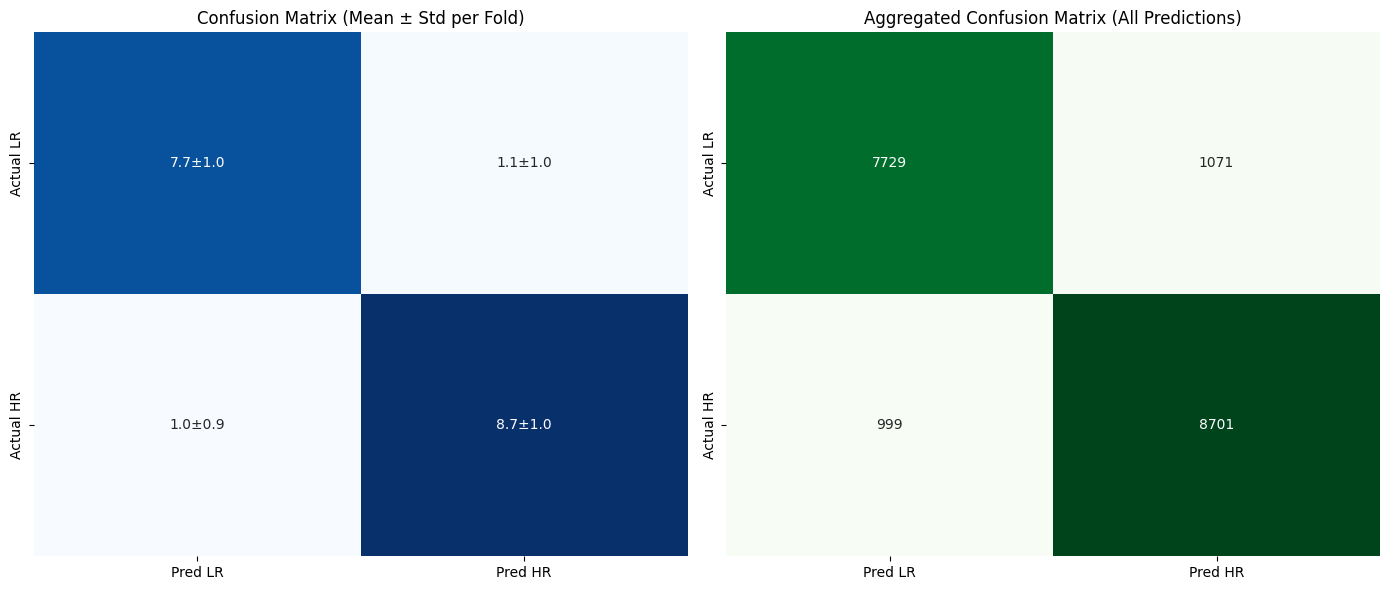

Side-by-side confusion matrices saved as 'confusion_matrices_side_by_side.png'


In [34]:
# ============================================================
# COMPREHENSIVE SUMMARY OUTPUT
# ============================================================
print(f"\n{'='*80}")
print(f"BEST MODEL SUMMARY: n={best_n} features (out of {n_features_total})")
print(f"Based on {n_repeats} repeats × {n_splits} folds = {total_iterations} total evaluations")
print(f"{'='*80}")

print(f"\n{'-'*80}")
print("OVERALL METRICS (Mean ± Std across all folds):")
print(f"{'-'*80}")
print(f"  Accuracy:    {mean_accuracies[best_idx]:.4f} ± {std_accuracies[best_idx]:.4f}")
print(f"  Sensitivity: {mean_sensitivities[best_idx]:.4f} ± {std_sensitivities[best_idx]:.4f}")
print(f"  Specificity: {mean_specificities[best_idx]:.4f} ± {std_specificities[best_idx]:.4f}")

print(f"\n{'-'*80}")
print("PER-CLASS METRICS (Mean ± Std across all folds):")
print(f"{'-'*80}")
print(f"\nLR (Low Risk) - Class 0:")
print(f"  Precision: {mean_precision_LR[best_idx]:.4f} ± {std_precision_LR[best_idx]:.4f}")
print(f"  Recall:    {mean_recall_LR[best_idx]:.4f} ± {std_recall_LR[best_idx]:.4f}")
print(f"  F1-Score:  {mean_f1_LR[best_idx]:.4f} ± {std_f1_LR[best_idx]:.4f}")

print(f"\nHR (High Risk) - Class 1:")
print(f"  Precision: {mean_precision_HR[best_idx]:.4f} ± {std_precision_HR[best_idx]:.4f}")
print(f"  Recall:    {mean_recall_HR[best_idx]:.4f} ± {std_recall_HR[best_idx]:.4f}")
print(f"  F1-Score:  {mean_f1_HR[best_idx]:.4f} ± {std_f1_HR[best_idx]:.4f}")

print(f"\n{'-'*80}")
print("AVERAGED METRICS:")
print(f"{'-'*80}")
print(f"\nMacro Average (unweighted mean of per-class metrics):")
print(f"  Precision: {mean_precision_macro[best_idx]:.4f} ± {std_precision_macro[best_idx]:.4f}")
print(f"  Recall:    {mean_recall_macro[best_idx]:.4f} ± {std_recall_macro[best_idx]:.4f}")
print(f"  F1-Score:  {mean_f1_macro[best_idx]:.4f} ± {std_f1_macro[best_idx]:.4f}")

print(f"\nWeighted Average (weighted by class support):")
print(f"  Precision: {mean_precision_weighted[best_idx]:.4f} ± {std_precision_weighted[best_idx]:.4f}")
print(f"  Recall:    {mean_recall_weighted[best_idx]:.4f} ± {std_recall_weighted[best_idx]:.4f}")
print(f"  F1-Score:  {mean_f1_weighted[best_idx]:.4f} ± {std_f1_weighted[best_idx]:.4f}")

print(f"\n{'-'*80}")
print(f"CONFUSION MATRIX (Mean ± Std per fold):")
print(f"{'-'*80}")
print(f"                    Predicted")
print(f"                 LR              HR")
print(f"Actual  LR  {tn_mean:6.1f}±{tn_std:5.2f}  {fp_mean:6.1f}±{fp_std:5.2f}")
print(f"        HR  {fn_mean:6.1f}±{fn_std:5.2f}  {tp_mean:6.1f}±{tp_std:5.2f}")

print(f"\n{'-'*80}")
print(f"AGGREGATED CONFUSION MATRIX (all {len(y_true_agg)} predictions combined):")
print(f"{'-'*80}")
tn_agg, fp_agg, fn_agg, tp_agg = cm_aggregated.ravel()
print(f"                 Predicted")
print(f"              LR       HR")
print(f"Actual  LR  {tn_agg:5d}  {fp_agg:5d}")
print(f"        HR  {fn_agg:5d}  {tp_agg:5d}")

print(f"\n{'-'*80}")
print(f"MOST FREQUENTLY SELECTED {best_n} FEATURES:")
print(f"{'-'*80}")
print(f"{'Rank':<6} {'Feature Name':<50} {'Selection Frequency':<25}")
print(f"{'-'*80}")
for rank, (feat_name, freq) in enumerate(zip(best_feature_names, best_feature_frequencies), 1):
    percentage = (freq / total_iterations) * 100
    print(f"{rank:<6} {feat_name:<50} {freq:>5}/{total_iterations} ({percentage:>5.1f}%)")

print(f"{'='*80}\n")

# ============================================================
# Save Best Features to CSV
# ============================================================
best_features_df = pd.DataFrame({
    'rank': range(1, len(best_feature_names) + 1),
    'feature_name': best_feature_names,
    'selection_count': best_feature_frequencies,
    'selection_percentage': [(f / total_iterations) * 100 for f in best_feature_frequencies]
})
best_features_df.to_csv(f'best_{best_n}_features.csv', index=False)
print(f"Best features saved to 'best_{best_n}_features.csv'")

# ============================================================
# Save Best Model Summary to Text File
# ============================================================
with open('best_model_summary.txt', 'w') as f:
    f.write(f"{'='*80}\n")
    f.write(f"BEST MODEL SUMMARY: n={best_n} features (out of {n_features_total})\n")
    f.write(f"Based on {n_repeats} repeats × {n_splits} folds = {total_iterations} total evaluations\n")
    f.write(f"{'='*80}\n\n")

    f.write(f"{'-'*80}\n")
    f.write("OVERALL METRICS (Mean ± Std across all folds):\n")
    f.write(f"{'-'*80}\n")
    f.write(f"  Accuracy:    {mean_accuracies[best_idx]:.4f} ± {std_accuracies[best_idx]:.4f}\n")
    f.write(f"  Sensitivity: {mean_sensitivities[best_idx]:.4f} ± {std_sensitivities[best_idx]:.4f}\n")
    f.write(f"  Specificity: {mean_specificities[best_idx]:.4f} ± {std_specificities[best_idx]:.4f}\n\n")

    f.write(f"{'-'*80}\n")
    f.write("PER-CLASS METRICS (Mean ± Std across all folds):\n")
    f.write(f"{'-'*80}\n")
    f.write(f"\nLR (Low Risk) - Class 0:\n")
    f.write(f"  Precision: {mean_precision_LR[best_idx]:.4f} ± {std_precision_LR[best_idx]:.4f}\n")
    f.write(f"  Recall:    {mean_recall_LR[best_idx]:.4f} ± {std_recall_LR[best_idx]:.4f}\n")
    f.write(f"  F1-Score:  {mean_f1_LR[best_idx]:.4f} ± {std_f1_LR[best_idx]:.4f}\n\n")

    f.write(f"HR (High Risk) - Class 1:\n")
    f.write(f"  Precision: {mean_precision_HR[best_idx]:.4f} ± {std_precision_HR[best_idx]:.4f}\n")
    f.write(f"  Recall:    {mean_recall_HR[best_idx]:.4f} ± {std_recall_HR[best_idx]:.4f}\n")
    f.write(f"  F1-Score:  {mean_f1_HR[best_idx]:.4f} ± {std_f1_HR[best_idx]:.4f}\n\n")

    f.write(f"{'-'*80}\n")
    f.write("AVERAGED METRICS:\n")
    f.write(f"{'-'*80}\n")
    f.write(f"\nMacro Average:\n")
    f.write(f"  Precision: {mean_precision_macro[best_idx]:.4f} ± {std_precision_macro[best_idx]:.4f}\n")
    f.write(f"  Recall:    {mean_recall_macro[best_idx]:.4f} ± {std_recall_macro[best_idx]:.4f}\n")
    f.write(f"  F1-Score:  {mean_f1_macro[best_idx]:.4f} ± {std_f1_macro[best_idx]:.4f}\n\n")

    f.write(f"Weighted Average:\n")
    f.write(f"  Precision: {mean_precision_weighted[best_idx]:.4f} ± {std_precision_weighted[best_idx]:.4f}\n")
    f.write(f"  Recall:    {mean_recall_weighted[best_idx]:.4f} ± {std_recall_weighted[best_idx]:.4f}\n")
    f.write(f"  F1-Score:  {mean_f1_weighted[best_idx]:.4f} ± {std_f1_weighted[best_idx]:.4f}\n\n")

    f.write(f"{'-'*80}\n")
    f.write(f"CONFUSION MATRIX (Mean ± Std per fold):\n")
    f.write(f"{'-'*80}\n")
    f.write(f"                    Predicted\n")
    f.write(f"                 LR              HR\n")
    f.write(f"Actual  LR  {tn_mean:6.1f}±{tn_std:5.2f}  {fp_mean:6.1f}±{fp_std:5.2f}\n")
    f.write(f"        HR  {fn_mean:6.1f}±{fn_std:5.2f}  {tp_mean:6.1f}±{tp_std:5.2f}\n\n")

    f.write(f"{'-'*80}\n")
    f.write(f"AGGREGATED CONFUSION MATRIX:\n")
    f.write(f"{'-'*80}\n")
    f.write(f"                 Predicted\n")
    f.write(f"              LR       HR\n")
    f.write(f"Actual  LR  {tn_agg:5d}  {fp_agg:5d}\n")
    f.write(f"        HR  {fn_agg:5d}  {tp_agg:5d}\n\n")

    f.write(f"{'-'*80}\n")
    f.write(f"MOST FREQUENTLY SELECTED {best_n} FEATURES:\n")
    f.write(f"{'-'*80}\n")
    for rank, (feat_name, freq) in enumerate(zip(best_feature_names, best_feature_frequencies), 1):
        percentage = (freq / total_iterations) * 100
        f.write(f"{rank}. {feat_name}: {freq}/{total_iterations} ({percentage:.1f}%)\n")

# ============================================================
# VISUALIZE CONFUSION MATRICES SIDE BY SIDE (SEABORN)
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----- Mean ± Std confusion matrix values -----
mean_cm = np.array([
    [tn_mean, fp_mean],
    [fn_mean, tp_mean]
])

std_cm = np.array([
    [tn_std, fp_std],
    [fn_std, tp_std]
])

# Create annotation strings: mean ± std
annot_mean_std = np.array([
    [f"{tn_mean:.1f}±{tn_std:.1f}", f"{fp_mean:.1f}±{fp_std:.1f}"],
    [f"{fn_mean:.1f}±{fn_std:.1f}", f"{tp_mean:.1f}±{tp_std:.1f}"]
])

# ----- Aggregated confusion matrix -----
annot_agg = np.array([
    [f"{tn_agg}", f"{fp_agg}"],
    [f"{fn_agg}", f"{tp_agg}"]
])

# ----- Plot -----
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mean ± Std Confusion Matrix
sns.heatmap(
    mean_cm,
    annot=annot_mean_std,
    fmt="",
    cmap="Blues",
    cbar=False,
    xticklabels=["Pred LR", "Pred HR"],
    yticklabels=["Actual LR", "Actual HR"],
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Mean ± Std per Fold)", fontsize=12)

# Aggregated Confusion Matrix
sns.heatmap(
    [[tn_agg, fp_agg],
     [fn_agg, tp_agg]],
    annot=annot_agg,
    fmt="",
    cmap="Greens",
    cbar=False,
    xticklabels=["Pred LR", "Pred HR"],
    yticklabels=["Actual LR", "Actual HR"],
    ax=axes[1]
)
axes[1].set_title("Aggregated Confusion Matrix (All Predictions)", fontsize=12)

plt.tight_layout()
plt.savefig("confusion_matrices_side_by_side.png", dpi=300)
plt.show()

print("Side-by-side confusion matrices saved as 'confusion_matrices_side_by_side.png'")


In [35]:
print(f"  ROC–AUC:     {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")


  ROC–AUC:     0.9568 ± 0.0000
